In [53]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
import copy
from sklearn.model_selection import cross_val_score

In [ ]:
""" READ ME
Content:
first cell holds the functions
in the next cell the functions are run,
after that results are printed
after that some remarks are made regarding the data
"""

In [68]:
class DataAnalyzer:
    def __init__(self):
        file_path = 'pricerunner_aggregate.csv'

        self.dataset = pd.read_csv(file_path, header=None)
        self.dataset.columns = self.dataset.iloc[0]

        self.dataset = self.dataset.drop(0)
        self.dataset.columns = self.dataset.columns.map(lambda x: x.strip())
        self.original_dataset = copy.deepcopy(self.dataset)
        self.fill_nan_vals()
        self.encode_categorical()

  
    def fill_nan_vals(self):
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Non-numerical column
                mode_val = self.dataset[column].mode()[0]
                self.dataset[column] = self.dataset[column].fillna(mode_val)
            else:  # Numerical column
                mean_val = self.dataset[column].mean()
                self.dataset[column] = self.dataset[column].fillna(mean_val)

    def drop_nan_vals(self):
        self.dataset = self.dataset.dropna()
        
    def encode_categorical(self):
        label_encoder = LabelEncoder()
        for column in self.dataset.columns:
            if self.dataset[column].dtype == 'object':  # Check if column is categorical
                encoded_values = label_encoder.fit_transform(self.dataset[column])
                self.dataset[column] = encoded_values


    def show_boxplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.boxplot(y=k, data=self.dataset, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_outlier_percs(self):
        for k, v in self.dataset.items():
            q1 = v.quantile(0.25)
            q3 = v.quantile(0.75)
            irq = q3 - q1
            v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
            perc = np.shape(v_col)[0] * 100.0 / np.shape(self.dataset)[0]
            print("Column %s outliers = %.2f%%" % (k, perc))

    def remove_outliers(self):
        self.dataset = self.dataset[~((self.dataset['stage'] > 7.0) | (self.dataset['stage'] < 4.0))]
        return self.dataset

    def normalize_df_by_max(self):
        columns_to_exclude=['Cluster Label', 'Category Label', 'Category ID']
        normalized_df = self.dataset.copy()
        for column in self.dataset.columns:
            if column not in columns_to_exclude:
                max_abs_value = abs(self.dataset[column]).max()
                normalized_df[column] = self.dataset[column] / max_abs_value

        self.dataset = normalized_df
        return self.dataset

    def normalize_df_by_mean(self):
        sc = StandardScaler()
        self.X_train = sc.fit_transform(self.X_train)
        self.X_test = sc.transform(self.X_test)
        return(self.X_train, self.X_test)
    
    def show_histplots(self):
        fig, axs = plt.subplots(ncols=7, nrows=2, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for k,v in self.dataset.items():
            sns.histplot(v, ax=axs[index])
            index += 1
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def show_heat_map(self):
        plt.figure(figsize=(20, 10))
        sns.heatmap(self.dataset.corr().abs(),  annot=True)

    def plot_variations(self):
        min_max_scaler = preprocessing.MinMaxScaler()
        column_sels = self.dataset.columns
        x = self.dataset.loc[:,column_sels]
        y = self.dataset['Category Label']
        # x = pd.DataFrame(data=min_max_scaler.fit_transform(x), columns=column_sels)
        fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20, 10))
        index = 0
        axs = axs.flatten()
        for i, k in enumerate(column_sels):
            sns.regplot(y=y, x=x[k], ax=axs[i])
        plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

    def get_x_and_Y(self):
        self.X = self.dataset.iloc[:, list(range(6))].values
        self.y = self.dataset.iloc[:, -1].values
        return (self.X, self.y)

    def get_train_test_split(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X, self.y, test_size = 0.20, random_state = 0)
        return (self.X_train, self.X_test, self.y_train, self.y_test)

    def perform_knn(self):
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
        classifier.fit(self.X_train, self.y_train)
        y_pred = classifier.predict(self.X_test)
        self.cm = confusion_matrix(self.y_test, y_pred)
        self.ac = accuracy_score(self.y_test,y_pred)
        return self.ac
    
    def perform_kfold_cv(self):
        classifier = KNeighborsClassifier(n_neighbors = 40, metric = 'minkowski', p = 2.7)
    
        cv_scores = cross_val_score(classifier, self.X_train, self.y_train, cv=5)  # Specify the number of folds (k) with cv parameter

        # Print the cross-validation scores
        return (cv_scores.mean(), cv_scores.max(), cv_scores)

class Master:
    def __init__(self):
        self.results = {}
    
    def organize_results(self):
        items = []
        for k, v in self.results.items():
            print(k, v)
            if isinstance(v, dict):
                for xk, xv in v.items():
                    new_x_key = xk
                    items.append((new_x_key, xv))
            else:
                new_key = k
                items.append((new_key, v))
        r_items = dict(items)
        df = pd.DataFrame({'method': list(r_items.keys()), 'result': list(r_items.values())})
        return df

    def run_raw(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["raw_run"] = anlyzr.perform_knn()
        return self.results["raw_run"]

    def run_after_max_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.normalize_df_by_max()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        self.results["after_max_normalisation_run"] = anlyzr.perform_knn()
        return self.results["after_max_normalisation_run"]

    def run_after_mean_normalisation(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        anlyzr.normalize_df_by_mean()
        self.results["after_mean_normalisation_run"] = anlyzr.perform_knn()
        return self.results["after_mean_normalisation_run"]
    
    def run_with_kfold(self):
        anlyzr = DataAnalyzer()
        anlyzr.get_x_and_Y()
        anlyzr.get_train_test_split()
        anlyzr.normalize_df_by_max()
        (k_mean, k_max, k_scores) = anlyzr.perform_kfold_cv()
        self.results["after_k_fold_run"] = {
            "k_mean": k_mean,
            "k_max" : k_max,
            "k_scores": k_scores
        }
    
    def run(self):
        self.run_raw()
        self.run_after_max_normalisation()
        self.run_after_mean_normalisation()
        self.run_with_kfold()
        return self.results


In [69]:
mstr = Master()
results = mstr.run()

In [70]:
results_df = mstr.organize_results()
display(results_df)

raw_run 0.964604275803483
after_max_normalisation_run 0.8926801642361603
after_mean_normalisation_run 0.9827268865920997
after_k_fold_run {'k_mean': 0.9598911609385011, 'k_max': 0.9637103912196849, 'k_scores': array([0.95823009, 0.95362832, 0.96230088, 0.96158612, 0.96371039])}


,method,result
0,raw_run,0.964604
1,after_max_normalisation_run,0.89268
2,after_mean_normalisation_run,0.982727
3,k_mean,0.959891
4,k_max,0.96371
5,k_scores,"[0.9582300884955752, 0.9536283185840708, 0.962..."


In [ ]:
"""
There was not much difference in applying different methods to this data set, there is a possibility, that one of the variables is highly correlated, or there is a chance of overfittion

"""

In [64]:
anlyzr = DataAnalyzer()

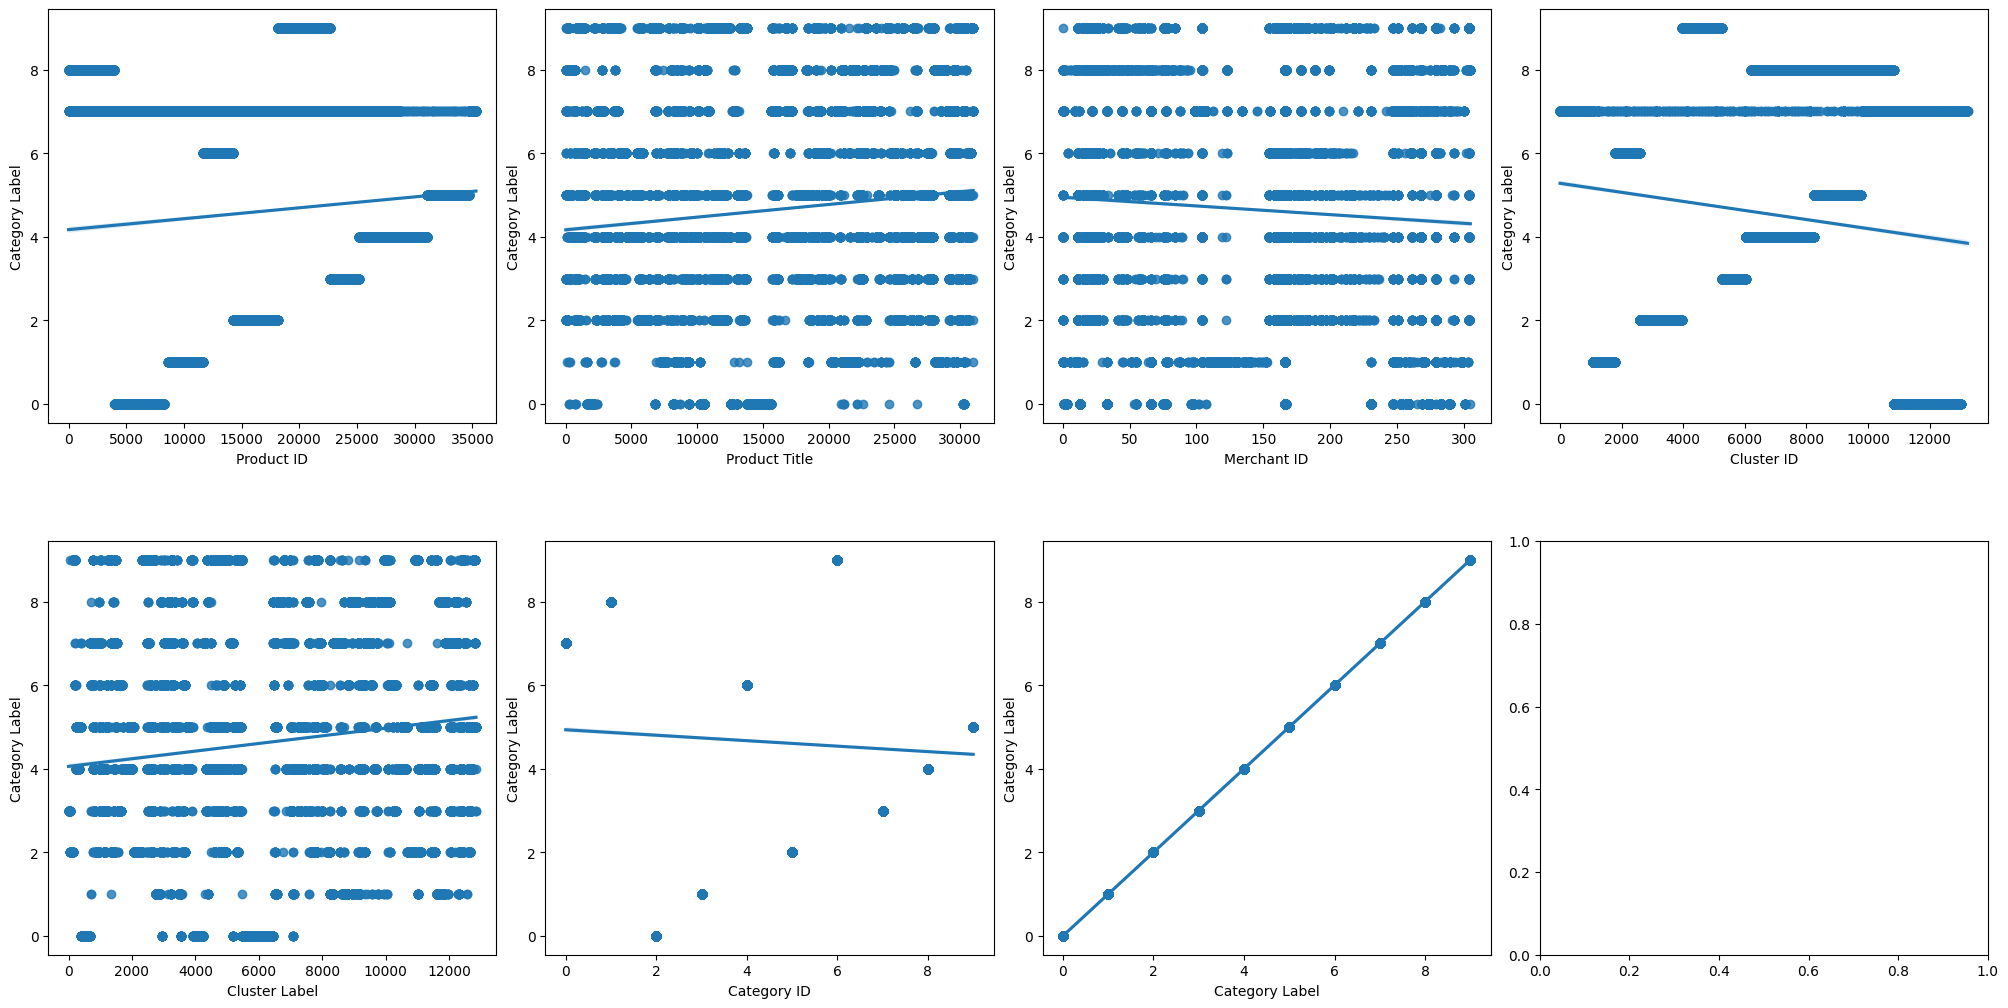

In [65]:
anlyzr.plot_variations()